In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, entropy, skew
from scipy.signal import welch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:

# 원본 데이터 로드
data_path = r'.\combined_fall_detection_data.csv'
df_origin = pd.read_csv(data_path)

# Spectral Entropy 계산 함수
def calculate_spectral_entropy(signal):
    f, Pxx = welch(signal, nperseg=len(signal))
    Pxx_norm = Pxx / Pxx.sum()
    return entropy(Pxx_norm)

# 심박수 계산 함수
def calculate_heart_rate(signal, time, duration):
    rising_edges = [i for i in range(1, len(signal)) if signal[i - 1] == 0 and signal[i] == 1023]
    falling_edges = [i for i in range(1, len(signal)) if signal[i - 1] == 1023 and signal[i] == 0]
    heartbeat_count = max(len(rising_edges), len(falling_edges))
    bpm = (heartbeat_count / duration) * 60
    differences = [time[rising_edges[i + 1]] - time[rising_edges[i]] for i in range(len(rising_edges) - 1) if rising_edges[i + 1] < len(time)]
    differences = np.array(differences)
    nn50 = np.sum(np.abs(differences) > 0.05)
    rmssd = np.sqrt(np.mean(differences**2))
    sdsd = np.std(differences)
    return bpm, nn50, rmssd, sdsd

# 데이터 전처리 함수 (1초 또는 3초 간격)
def preprocess_data(time):
    results = []
    for (subject, status), group in df_origin.groupby(['subject', 'status']):
        group['combined_time'] = group['time_5'] * 60 + group['time_6']
        min_time, max_time = group['combined_time'].min(), group['combined_time'].max()
        for start_time in np.arange(min_time, max_time, time):
            end_time = start_time + time
            interval_group = group[(group['combined_time'] >= start_time) & (group['combined_time'] < end_time)]
            if interval_group.empty:
                continue

            features = {'subject': subject, 'status': status, 'interval': f"{round(start_time, 1)}-{round(end_time, 1)}초"}
            for axis in ['ax', 'ay', 'az']:
                signal = interval_group[axis].values
                features[f'{axis}_kurtosis'] = kurtosis(signal)
                features[f'{axis}_spectral_entropy'] = calculate_spectral_entropy(signal)
                features[f'{axis}_time_energy'] = np.sum(signal ** 2)
                features[f'{axis}_activity_count'] = np.sum(np.abs(np.diff(signal)))

            bpm, nn50, rmssd, sdsd = calculate_heart_rate(interval_group['heart'].values, interval_group['combined_time'].values, duration=time)
            features.update({'BPM': bpm, 'NN50': nn50, 'RMSSD': rmssd, 'SDSD': sdsd})

            for sensor in ['w', 'x', 'y', 'z', 'ax', 'ay', 'az']:
                if sensor in interval_group.columns:
                    mean_value = interval_group[sensor].mean()
                    mad_value = (interval_group[sensor] - mean_value).abs().mean()
                    features.update({
                        f'{sensor}_mean': mean_value, f'{sensor}_median': interval_group[sensor].median(),
                        f'{sensor}_std': interval_group[sensor].std(), f'{sensor}_mad': mad_value,
                        f'{sensor}_skew': skew(interval_group[sensor].dropna())
                    })

            results.append(features)
    return pd.DataFrame(results).round(4)


def cluster_fall_stages(df, num_clusters=3):
    results = []
    for (subject, status), group in df.groupby(['subject', 'status']):
        # ✅ 변화량 (change_magnitude) 계산
        change_magnitude = (
            np.abs(group['ax_time_energy'].diff()) +
            np.abs(group['ay_time_energy'].diff()) +
            np.abs(group['az_time_energy'].diff()) +
            np.abs(group['ax_activity_count'].diff()) +
            np.abs(group['ay_activity_count'].diff()) +
            np.abs(group['az_activity_count'].diff())
        ).fillna(0)

        # ✅ 표준화 (StandardScaler 적용)
        scaler = StandardScaler()
        change_magnitude_scaled = scaler.fit_transform(change_magnitude.values.reshape(-1, 1))

        # ✅ KMeans 클러스터링 적용 (3개 그룹)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(change_magnitude_scaled)

        # ✅ 클러스터 중심값을 기준으로 `fall_stage` 할당
        cluster_centers = kmeans.cluster_centers_.flatten()
        cluster_order = np.argsort(cluster_centers)  # 클러스터를 작은 값부터 정렬
        cluster_mapping = {cluster_order[0]: 'standing', cluster_order[1]: 'falling', cluster_order[2]: 'fallen'}

        # ✅ 클러스터링 결과 적용
        group['fall_stage'] = [cluster_mapping[label] for label in cluster_labels]

        # ✅ 🔹 시간 순서 반영하여 `fall_stage` 조정 🔹
        total_steps = len(group)
        standing_end = int(total_steps * 0.3)  # 30%까지 `standing`
        falling_end = int(total_steps * 0.7)  # 30~70%까지 `falling`
        
        group.iloc[:standing_end, group.columns.get_loc('fall_stage')] = 'standing'
        group.iloc[standing_end:falling_end, group.columns.get_loc('fall_stage')] = 'falling'
        group.iloc[falling_end:, group.columns.get_loc('fall_stage')] = 'fallen'

        results.append(group)

    return pd.concat(results)


In [4]:
# 1초
df_1sec = preprocess_data(1)
df_1sec_labeled = cluster_fall_stages(df_1sec)

# 낙상 데이터만 선택
df_1sec_labeled = df_1sec_labeled[df_1sec_labeled['status'].str.contains('fall')]

# CSV 파일로 저장
df_1sec_labeled.to_csv('new_fall_data_1sec_clustered_time_adjusted.csv', index=False)



c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_

In [5]:
# 3초
df_3sec = preprocess_data(3)
df_3sec_labeled = cluster_fall_stages(df_3sec)
df_3sec_labeled = df_3sec_labeled[df_3sec_labeled['status'].str.contains('fall')]
df_3sec_labeled.to_csv('new_fall_data_3sec_clustered_time_adjusted.csv', index=False)

c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\angel\anaconda3\envs\opencv312\Lib\site-packages\numpy\_

In [ ]:
df_3sec_labeled[df_3sec_labeled['status']=='fall2']

In [6]:
import matplotlib.pyplot as plt

def plot_fall_data(df, subject, status):
    """
    특정 subject와 status의 데이터를 시각화하는 함수.
    
    Args:
    - df (DataFrame): 데이터셋 (df_3sec_labeled 등)
    - subject (int): 시각화할 subject 번호
    - status (str): 시각화할 status (예: 'fall_1', 'fall_2' 등)
    """
    # Convert fall_stage to numeric values for better visualization
    df['fall_stage_numeric'] = df['fall_stage'].map({'standing': 0, 'falling': 1, 'fallen': 2})

    # 특정 subject와 status에 해당하는 데이터 필터링
    subject_fall1 = df[(df['subject'] == subject) & (df['status'] == status)]
    
    if subject_fall1.empty:
        print(f"⚠ 데이터 없음: subject={subject}, status={status}")
        return

    plt.figure(figsize=(12, 15))

    # Plot kurtosis data
    plt.subplot(3, 1, 1)
    plt.plot(subject_fall1.index, subject_fall1['ax_kurtosis'], label='ax', linestyle='-')
    plt.plot(subject_fall1.index, subject_fall1['ay_kurtosis'], label='ay', linestyle='-.')
    plt.plot(subject_fall1.index, subject_fall1['az_kurtosis'], label='az', linestyle=':')
    plt.plot(subject_fall1.index, subject_fall1['fall_stage_numeric'] * 10, label='stage', linestyle=':', color='red')
    plt.title(f'Time Series Data for {subject} {status} - Kurtosis')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()

    # Plot ax, ay, az time energy data
    plt.subplot(3, 1, 2)
    plt.plot(subject_fall1.index, subject_fall1['ax_time_energy'], label='ax', linestyle='-')
    plt.plot(subject_fall1.index, subject_fall1['ay_time_energy'], label='ay', linestyle='--')
    plt.plot(subject_fall1.index, subject_fall1['az_time_energy'], label='az', linestyle='-.')
    plt.plot(subject_fall1.index, subject_fall1['fall_stage_numeric'] * 10, label='stage', linestyle=':', color='red')
    plt.title(f'Time Series Data for {subject} {status} - Time Energy')
    plt.xlabel('Time Steps')
    plt.ylabel('Acceleration Values')
    plt.legend()


    # Plot ax, ay, az activity count data
    plt.subplot(3, 1, 3)
    plt.plot(subject_fall1.index, subject_fall1['ax_activity_count'], label='ax', linestyle='-')
    plt.plot(subject_fall1.index, subject_fall1['ay_activity_count'], label='ay', linestyle='--')
    plt.plot(subject_fall1.index, subject_fall1['az_activity_count'], label='az', linestyle='-.')
    plt.plot(subject_fall1.index, subject_fall1['fall_stage_numeric'] * 10, label='stage', linestyle=':', color='red')
    plt.title(f'Time Series Data for {subject} {status} - Activity Count')
    plt.xlabel('Time Steps')
    plt.ylabel('Acceleration Values')
    plt.legend()


    plt.tight_layout()
    plt.show()




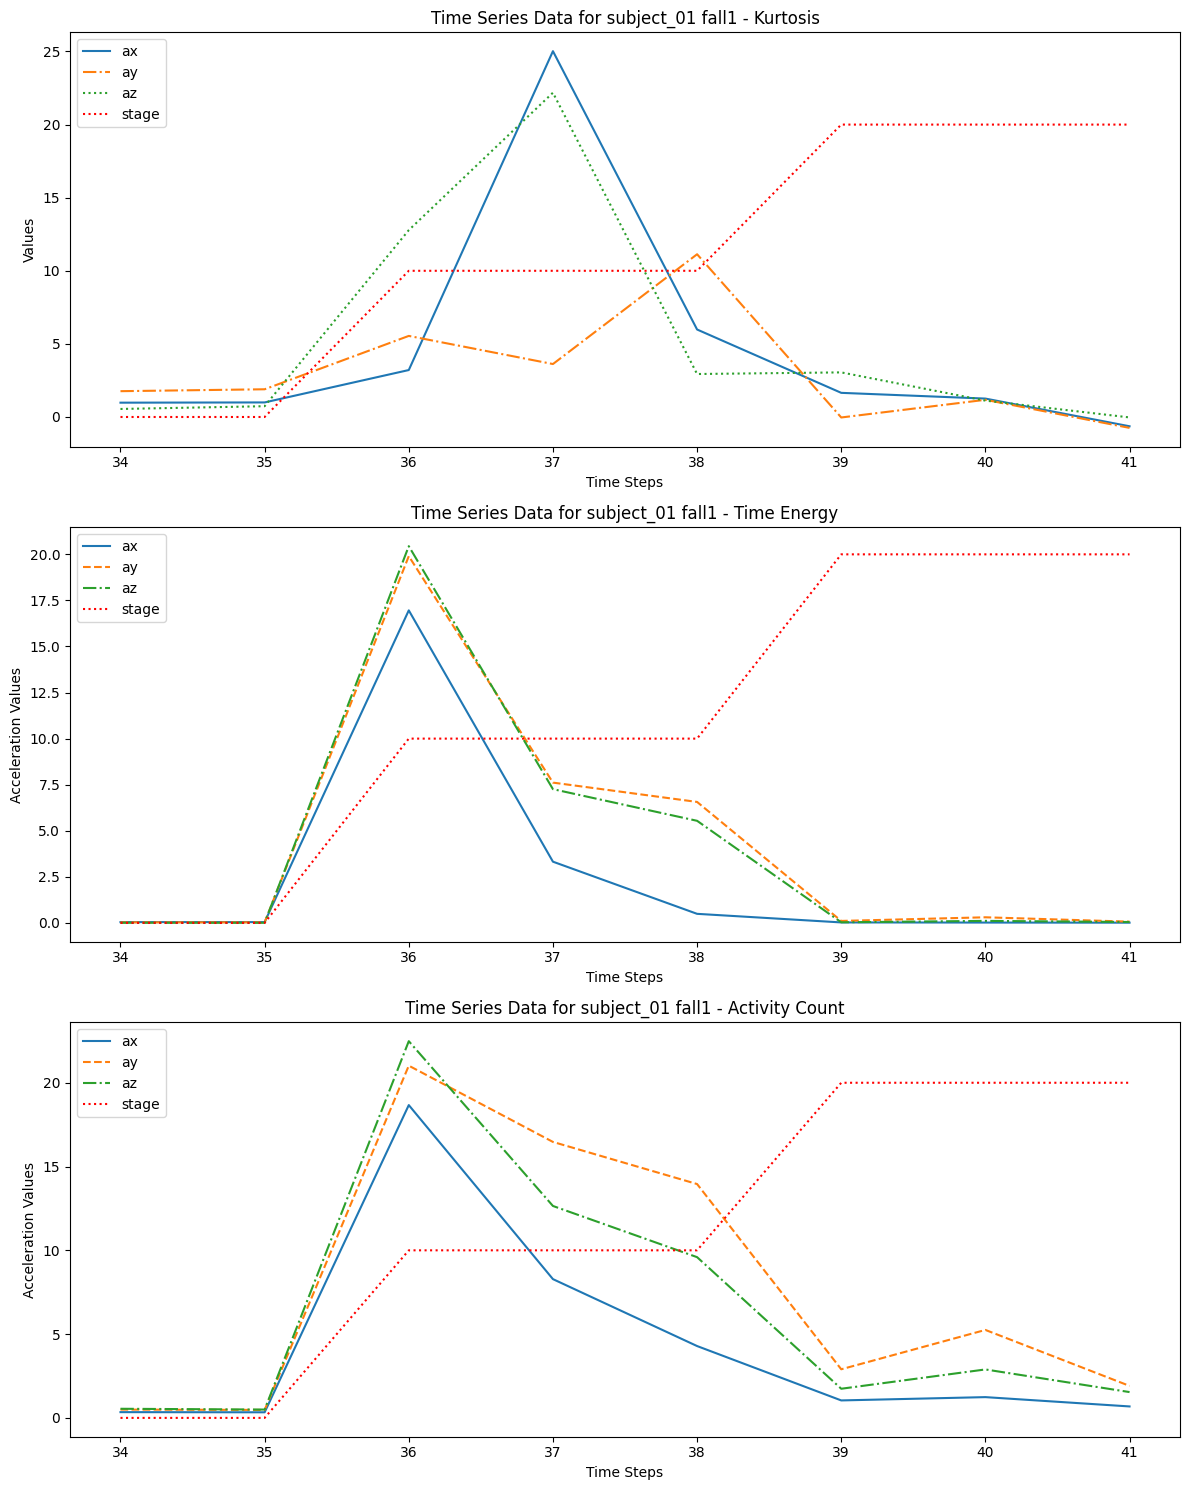

In [9]:
# ✅ 예제 실행 (subject=1, status='fall_1'일 경우)
plot_fall_data(df_3sec_labeled, subject='subject_01', status='fall1')